## Is it a hotdog?

This was created from the [fastbook course](https://github.com/fastai/fastbook). I changed birds to hotdogs and not much else other than export the model.

In [7]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [8]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
import os

!pip install -Uqq fastai duckduckgo_search

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "hotdog photos"
1. Use DuckDuckGo to search for images of "hamburger photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a hotdog and see if it works.

## Step 1: Download images of hotdogs and not-hotdogs

In [9]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a hotdog photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [10]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('hotdog photos', max_images=1)
urls[0]

Searching for 'hotdog photos'


'https://cottagelife.com/wp-content/uploads/2018/09/shutterstock_290273714.jpg'

...and then download a URL and take a look at it:

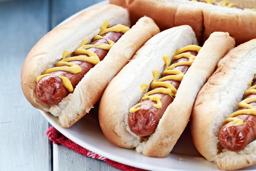

In [11]:
from fastdownload import download_url
dest = 'hotdog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "hamburger photos":

Searching for 'hamburger photos'


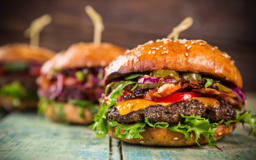

In [12]:
download_url(search_images('hamburger photos', max_images=1)[0], 'hamburger.jpg', show_progress=False)
Image.open('hamburger.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "hotdog" and "hamburger" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [13]:
searches = 'hamburger','hotdog'
path = Path('hotdog_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} baseball photos'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} ketchup'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'hamburger photo'
Searching for 'hamburger baseball photos'
Searching for 'hamburger ketchup'
Searching for 'hotdog photo'
Searching for 'hotdog baseball photos'
Searching for 'hotdog ketchup'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

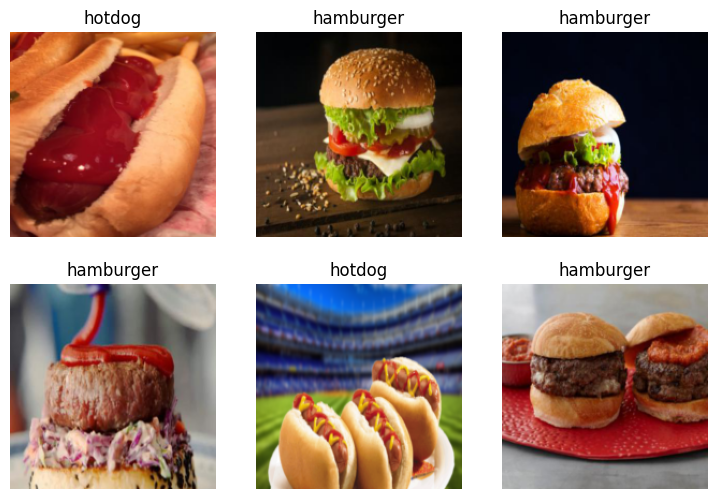

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "hotdog" or "hamburger").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.250279,1.582637,0.419355,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.481483,0.370073,0.129032,00:23
1,0.340492,0.224555,0.064516,00:34
2,0.238500,0.270269,0.064516,00:26


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use the model.

Let's see what our model thinks about that bird we downloaded at the start:

In [17]:
is_hotdog,_,probs = learn.predict('hotdog.jpg')
print(f"This is a: {is_hotdog}.")
print(f"Probability it's a hotdog: {probs[0]:.4f}")

This is a: hotdog.
Probability it's a hotdog: 0.0005


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

Export the model

In [18]:
learn.export('hotdog_nothotdog.pkl')